# TDA Mapper
Notebook supporting 

*A Topological Data Analysis Mapper of the ovarian folliculogenesis based on MALDI Mass Spectrometry Imaging proteomics*, 
Giulia Campi, Giovanna Nicora, Giulia Fiorentino, Andrew Smith, Fulvio Magni, Silvia Garagna, Maurizio Zuccotti, Riccardo Bellazzi.

In [399]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_style('whitegrid')
import os
import cufflinks as cf
import plotly.express as px
from kmapper import jupyter

Import spectral data from spots and spatial data for each section. Each section is named with the following format: $T.F.S$, where 
- $T$ represents the follicular growth stage,
- $F$ represets the follicle identifier within the follicular growth stage,
- $S$ represents the section identifier within the specified follicle; S = 0 is the equatorial section.

In [387]:
path = '/Users/giuliacampi/Documents/Universita/Laurea_Magistrale/Tesi/Dati/'
# Import spectral data from spots
df = pd.read_csv(path + 'prot_df.csv', index_col=0)
repeated_spots = df.groupby('spot').count()
repeated_spots = repeated_spots[repeated_spots['foll_id'] > 1].index
for spot in repeated_spots:
    ids = df[df['spot'] == spot].index
    df.drop(ids, axis = 0, inplace = True)
foll_types = df.drop(['spot'],axis=1).groupby('foll_id')['type'].max()
mz_list = df.drop(['foll_id','spot','type'], axis = 1).columns
# Import spatial data for each section
sections_data = {}
for d in os.listdir(path + 'NewSpatialMatrix'):
    if d != '.DS_Store':
        for f in os.listdir(path + 'NewSpatialMatrix/' + d):
            dff = pd.read_csv(path + 'NewSpatialMatrix/' + d + '/' + f)  
            dff['X'] = [int(str(x).split('.')[0]) for x in dff['X']]      
            dff.columns = ['X'] + [y.split('.')[0] for y in dff.drop('X', axis = 1).columns] 
            sections_data[f.split(' ')[0]] = dff

In [388]:
prot_dict = pd.read_excel(pd.ExcelFile(path + 'protein_identification.xlsx'))
prot_dict.columns = ['prot', 'mz','other_prots']
xticks = []
for i in np.arange(prot_dict.shape[0]):
    label = prot_dict.iloc[i]['prot'].split('_')[0]
    count = 1
    other_prots = str(prot_dict.iloc[i]['other_prots'])
    if not other_prots.split(' ')[0] == 'nan':
        for other_prot in [p.split('_')[0] for p in other_prots.split(' ')]:
            if count == 1:
                label += ', ' + other_prot
            elif count == 5:
                label += ',\n' + other_prot
            else:
                label += ', ' + other_prot
            count +=1
    xticks.append(label)

Import the *Kullback–Leibler* divergence matrix computed in MATLAB and re-arrange sections order.

In [389]:
kl = pd.read_csv(path[:-5] + 'Risultati/TDAMapper/KLDivergence/KL.csv')
ordered_sections = [sect.split(' ')[0] for sect in list(kl.columns)]
reordered_sections_data = {k: sections_data[k] for k in ordered_sections}

Compute the aggregate spectrum of each section.

In [390]:
def get_aggregate_spectrum(sect,aggregate_fun):
    new_df = pd.DataFrame(columns=df.drop(['type','foll_id','spot'],axis=1).columns)
    for col in sect.drop('X',axis=1).columns:
        for spot in list(sect[col].dropna().values):
            a = df[df['spot'] == int(spot)+1].drop(['type','foll_id','spot'],axis=1)
            if len(a) > 0:
                new_df = new_df.append(a)
    if aggregate_fun == 'median':
        return new_df.median()
    elif aggregate_fun == 'max':
        return new_df.max()

In [391]:
sections_types = [int(s.split('.')[0][1]) for s in ordered_sections]
sections_folls = [s.split('.')[0] + '.' + s.split('.')[1] for s in ordered_sections]
sect_max = pd.DataFrame(columns=df.drop(['type','foll_id','spot'],axis=1).columns)
for sect in reordered_sections_data.values():
    sect_max = sect_max.append(get_aggregate_spectrum(sect,'max'), ignore_index = True)

## TDA Mapper

In [392]:
import sklearn
import kmapper as km
import umap

In [393]:
# Set Mapper parameters
lens = 'UMAP2'
distance = 'KL' 
n_clusters = 5
linkage = 'complete'
affinity = 'euclidean'
clusterer = sklearn.cluster.AgglomerativeClustering(n_clusters = n_clusters, linkage = linkage, affinity = affinity)
bins = 10
overlapping = 0.5
data = sect_max

In [394]:
# Create mapper and project data.
mapper = km.KeplerMapper()
projected_data = mapper.fit_transform(data.to_numpy(), projection= umap.UMAP(n_components=2,n_neighbors=30,random_state=14), distance_matrix = kl.to_numpy());

/Users/giuliacampi/anaconda3/lib/python3.8/site-packages/kmapper/kmapper.py:175: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison



In [395]:
# Cluster and create map.
graph = mapper.map(projected_data, data, cover = km.Cover(n_cubes = bins, perc_overlap = overlapping),
                   clusterer = clusterer);

In [398]:
html = mapper.visualize(graph, 
                 path_html = 'MapperGraph.html',
                 title= 'MALDI data - TDA Mapper',
                 color_values = np.array(sections_types),
                 #colorscale = px.colors.sequential.Viridis,
                 custom_tooltips = np.array(ordered_sections),
                 custom_meta={"Description":'MALDI sections',
                              "Distance": distance,
                              "Lens": lens,
                              "Cluster": "AgglomerativeClustering",
                              "n_clusters": n_clusters, 
                              "linkage": linkage,
                              "affinity": affinity,
                              "Color": "Follicular category"
                             })
jupyter.display('MapperGraph.html')

/Users/giuliacampi/anaconda3/lib/python3.8/site-packages/IPython/core/display.py:717: UserWarning:

Consider using IPython.display.IFrame instead



## Graph analysis

### Evaluation of graph quality based on entopry of its nodes.
To evaluate purity of nodes produced by the TDA Mapper algorithm, we computed the enrtopy of each cluster based on the  follicular growth stage (i.e. follicular type) of the clustered sections, and then computed its mean value, representative of the **mean graph entropy**. 

In [98]:
from scipy.stats import entropy
clusters = (list(graph['nodes'].keys()))
if 'list' in clusters:
    clusters.remove('list')
e_type = 0
for cluster in clusters:
    ind_list = graph['nodes'][cluster] 
    labels_type = []
    labels_cat = []
    labels_foll = []
    for i in ind_list:
        labels_type.append(sections_types[i]) #T4-T8   
    e_type += entropy(np.histogram(labels_type,bins = 5,range=(4,8))[0]/len(labels_type))
e_type = e_type/len(clusters)

print('Mean graph entropy = {}'.format(e_type))

Mean graph entropy = 0.4756633076222503


### Graph features
Given a graph $G = (V,E)$, we can compute:
- the **order** of the graph: $n = |V|$, i.e. the number of nodes in the graph, 
- the **size** of the graph: $m = |E|$, i.e. number of edges in the graph,
- the **density** of the graph, defined as the ratio of the number of edges present to the maximum possible: $\delta(G)=\frac{m}{\binom{n}{2}}$.

(***Ref.:*** John R. Ladd, Jessica Otis, Christopher N. Warren, and Scott Weingart, "Exploring and Analyzing Network Data with Python," The Programming Historian 6 (2017), https://doi.org/10.46430/phen0064)

In [99]:
import networkx as nx
nx_graph = km.adapter.to_nx(graph)

In [100]:
print('Graph order (#nodes): {}'.format(nx_graph.number_of_nodes()))
print('Graph size (#edges): {}'.format(nx_graph.number_of_edges()))
print('Graph density: {}'.format(nx.density(nx_graph)))

Graph order (#nodes): 465
Graph size (#edges): 1281
Graph density: 0.011874304783092324


### Centrality measures
Centrality measures represent the "importance" of nodes in the graph. Three of the most important centrality measures are *degree*, *betweenness centrality*, and *eigenvector centrality*. 

#### Degree
Degree is the simplest and the most common way of finding important nodes. A node's degree is the sum of its edges.  Nodes with high degrees in a network are the ones connected to the highest number of other nodes: these are often referred to as **hubs**.

In [101]:
from operator import itemgetter
sections_names = list(reordered_sections_data.keys())
def get_node_info(node_name):
    sections_ids = graph['nodes'][node_name]
    print('Node {}:'.format(node_name, sections_ids))
    for i in sections_ids:
        print(' - Section {}'.format(sections_names[i]))

In [102]:
degree_dict = dict(nx_graph.degree(nx_graph.nodes()))
sorted_degree = sorted(degree_dict.items(),key = itemgetter(1), reverse = True)
print("Top 5 nodes by degree (Hubs)")
i = 1
for d in sorted_degree[:5]:
    print()
    print(str(i) + '. ')
    i += 1
    get_node_info(d[0])

Top 5 nodes by degree (Hubs)

1. 
Node cube34_cluster1:
 - Section T4.4.-4
 - Section T4.9.-4
 - Section T5.13.-3
 - Section T5.13.-4
 - Section T5.13.1
 - Section T5.14.-1
 - Section T5.14.-6
 - Section T5.14.0
 - Section T5.14.5
 - Section T5.2.12
 - Section T5.3.-4
 - Section T5.5.1
 - Section T5.5.4
 - Section T5.5.5
 - Section T6.1.-1
 - Section T6.1.-2
 - Section T6.1.-4
 - Section T6.11.10
 - Section T6.9.-13

2. 
Node cube35_cluster0:
 - Section T5.1.5
 - Section T5.13.-3
 - Section T5.13.-4
 - Section T5.13.-7
 - Section T5.13.1
 - Section T5.14.-1
 - Section T5.14.-5
 - Section T5.14.-6
 - Section T5.14.0
 - Section T5.14.5
 - Section T5.5.1
 - Section T5.8.-3
 - Section T6.11.10
 - Section T6.11.7

3. 
Node cube48_cluster0:
 - Section T4.1.1
 - Section T4.14.-5
 - Section T4.14.-6
 - Section T4.15.-3
 - Section T4.17.3
 - Section T4.2.0
 - Section T5.1.-3
 - Section T5.14.-4
 - Section T6.10.-7
 - Section T6.11.1
 - Section T6.12.-5
 - Section T7.7.-2
 - Section T7.8.-2
 - S

#### Betweenness centrality
Betweenness centrality looks at all the shortest paths that pass through a particular node. To do this, it must first calculate every possible shortest path in your network. Betweenness centrality, which is also expressed on a scale of 0 to 1, is fairly good at finding nodes that connect two otherwise disparate parts of a network. If you’re the only thing connecting two clusters, every communication between those clusters has to pass through you. In contrast to a hub, this sort of node is often referred to as a **broker**. Betweenness centrality is not the only way of finding brokerage (and other methods are more systematic), but it’s a quick way of giving you a sense of which nodes are important not because they have lots of connections themselves but because they stand between groups, giving the network connectivity and cohesion.

In [103]:
betweenness_dict = nx.betweenness_centrality(nx_graph)
sorted_betweenness = sorted(betweenness_dict.items(), key=itemgetter(1), reverse=True)
print("Top 5 nodes by betweenness centrality (Brokers)")
for d in sorted_betweenness[:5]:
    get_node_info(d[0])

Top 5 nodes by betweenness centrality (Brokers)
Node cube67_cluster0:
 - Section T4.10.-4
 - Section T4.14.-1
 - Section T4.14.-2
 - Section T4.16.-2
 - Section T5.1.0
 - Section T5.3.-3
 - Section T6.11.3
 - Section T6.11.6
 - Section T6.12.4
 - Section T6.9.-5
 - Section T7.7.4
Node cube32_cluster0:
 - Section T5.2.0
 - Section T5.2.10
 - Section T5.2.9
 - Section T5.7.-6
 - Section T5.8.-2
 - Section T5.8.1
 - Section T6.14.0
 - Section T6.7.-3
 - Section T8.2.1
 - Section T8.2.3
Node cube35_cluster0:
 - Section T5.1.5
 - Section T5.13.-3
 - Section T5.13.-4
 - Section T5.13.-7
 - Section T5.13.1
 - Section T5.14.-1
 - Section T5.14.-5
 - Section T5.14.-6
 - Section T5.14.0
 - Section T5.14.5
 - Section T5.5.1
 - Section T5.8.-3
 - Section T6.11.10
 - Section T6.11.7
Node cube52_cluster0:
 - Section T5.2.11
 - Section T5.2.5
 - Section T5.2.7
 - Section T7.3.-2
Node cube54_cluster1:
 - Section T4.4.-3
 - Section T4.5.-5
 - Section T5.13.-2
 - Section T5.13.0
 - Section T6.9.-11


#### Eigenvector centrality
Eigenvector centrality is a kind of extension of degree, which looks at a combination of a node's edges and the edges of that node's neighbors. Eigenvector centrality cares if you are a hub, but it also cares how many hubs you are connected to. It’s calculated as a value from 0 to 1: the closer to 1, the greater the centrality. Eigenvector centrality is useful for understanding which nodes can get information to many other nodes quickly.

In [104]:
eigenvector_dict = nx.eigenvector_centrality(nx_graph,max_iter=1000)
sorted_eigenvector = sorted(eigenvector_dict.items(), key=itemgetter(1), reverse=True)
print("Top 5 nodes by eigenvector centrality")
for d in sorted_eigenvector[:5]:
    get_node_info(d[0])

Top 5 nodes by eigenvector centrality
Node cube76_cluster0:
 - Section T4.10.3
 - Section T4.12.3
 - Section T4.13.-1
 - Section T4.14.-2
 - Section T4.14.-3
 - Section T5.12.2
 - Section T5.12.8
 - Section T6.10.5
 - Section T6.10.6
 - Section T6.10.9
 - Section T6.12.4
 - Section T6.9.-5
 - Section T7.7.4
Node cube48_cluster0:
 - Section T4.1.1
 - Section T4.14.-5
 - Section T4.14.-6
 - Section T4.15.-3
 - Section T4.17.3
 - Section T4.2.0
 - Section T5.1.-3
 - Section T5.14.-4
 - Section T6.10.-7
 - Section T6.11.1
 - Section T6.12.-5
 - Section T7.7.-2
 - Section T7.8.-2
 - Section T7.8.-4
 - Section T7.8.0
Node cube67_cluster0:
 - Section T4.10.-4
 - Section T4.14.-1
 - Section T4.14.-2
 - Section T4.16.-2
 - Section T5.1.0
 - Section T5.3.-3
 - Section T6.11.3
 - Section T6.11.6
 - Section T6.12.4
 - Section T6.9.-5
 - Section T7.7.4
Node cube85_cluster2:
 - Section T4.10.-2
 - Section T4.10.-3
 - Section T4.10.4
 - Section T4.11.-3
 - Section T4.11.4
 - Section T4.12.3
 - Sectio

### Community detection
Find communities in graph using *Clauset-Newman-Moore* greedy modularity maximization, an agglomerative algorithm based on the maximization of **modularity**. Modularity is property of a network and a specific proposed division of that network into communities that measures when the division is good, in the sense that there are many edges within communities and only a few between them. 

(***Ref.*** Clauset, A., Newman, M., Moore, C.: Finding community structure in very large networks. Physical review. E, Statistical, nonlinear, and soft matter physics. 70, 066111 (2005). https://doi.org/10.1103/PhysRevE.70.066111)

In [105]:
def get_node_sections(node_name):
    sections_ids = graph['nodes'][node_name]
    s = []
    for i in sections_ids:
        s.append(sections_names[i])
    return s

In [106]:
from networkx.algorithms import community
communities = community.greedy_modularity_communities(nx_graph)
community_sections = {}
for i,c in enumerate(communities):
    sect_list = []
    for node in c:
        sect_list.append(get_node_sections(node))

    community_sections['c_'+str(i)] = [item for sublist in sect_list for item in sublist]
print('{} communities found.'.format(len(community_sections)))

33 communities found.



                                            Communities distributions


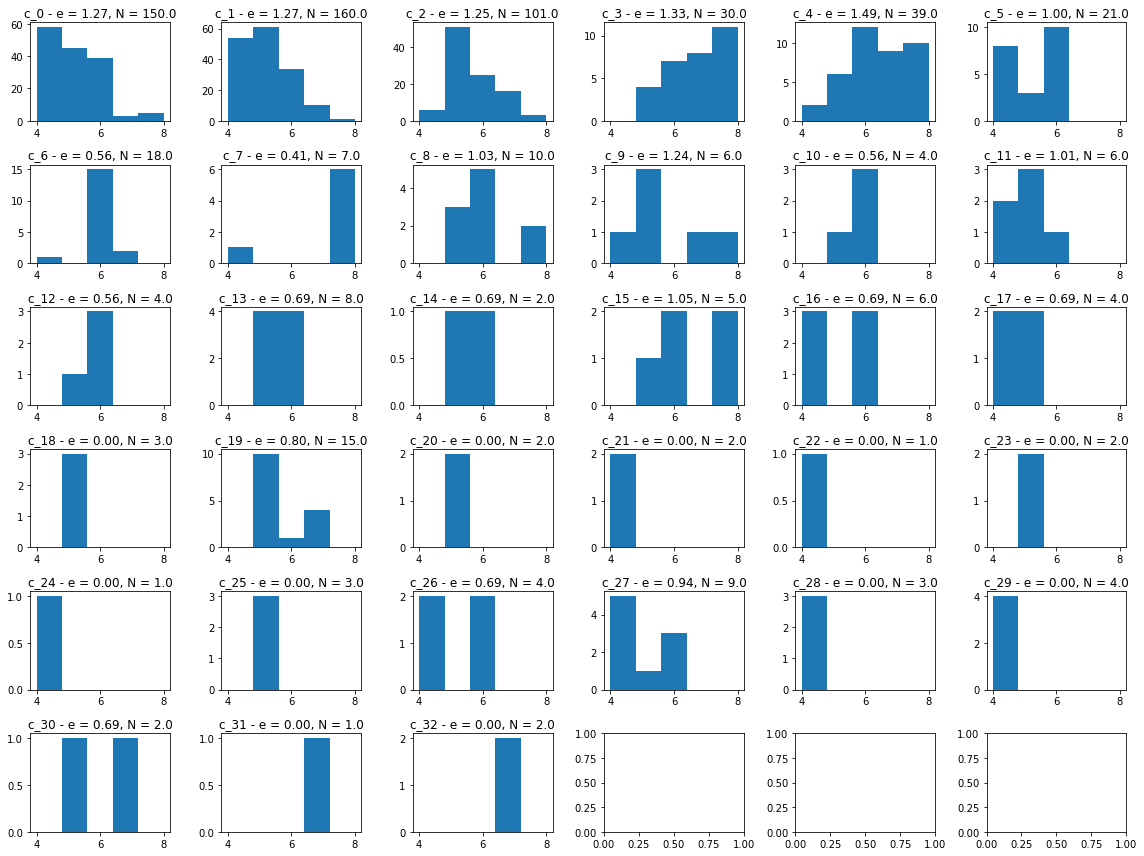

In [110]:
print()
print('                                            Communities distributions')
fig, axes = plt.subplots(6,6)
fig.set_figheight(12)
fig.set_figwidth(16)
community_analysis = {}
i = 0
for k,c in enumerate(community_sections):
    arr = np.array([0, 0], dtype='float64')
    unique_sections = pd.Series(community_sections[c]).unique()
    arr[0] = len(unique_sections)
    c_types = [int(sect.split('.')[0][1]) for sect in unique_sections]
    arr[1] = entropy(np.histogram(c_types, bins = 5, range = (4,8))[0])
    axes[i,np.mod(k,6)].hist(c_types, bins = 5, range = (4,8))
    axes[i,np.mod(k,6)].set_title('{} - e = {:.2f}, N = {}'.format(c,arr[1], arr[0]))
    if np.mod(k,6) == 5:
        i += 1
    community_analysis[c] = arr
plt.tight_layout()

Selection of the communities containing at least 4 different sections and with maximum entropy = 0.68. 

In [113]:
thresh_n = 4
thresh_e = 0.68
selected_communities = {}
for c in community_analysis:
    if (community_analysis[c][0] >= thresh_n) & (community_analysis[c][1] <= thresh_e):
        selected_communities[c] = community_analysis[c]
print('Selected communities (with N >= {} and entropy <= {}):'.format(thresh_n,thresh_e))
for c in selected_communities:
    print(c)

Selected communities (with N >= 4 and entropy <= 0.68):
c_6
c_7
c_10
c_12
c_29


Inspecting the selected communities, three of them are associated to specific follicular growth stages:
- c_6 &#8594; T6,
- c_7 &#8594; T8,
- c_29 &#8594; T4.

In [197]:
selected_communities = ['c_29', 'c_6', 'c_7']
communities_types = ['T4', 'T6', 'T8']
comparisons_types = ['T4-T6', 'T4-T8', 'T6-T8']

In [155]:
c_df = {}
for c in selected_communities:
    sections = pd.Series(community_sections[c]).unique()
    ids = []
    for s in sections:
        ids.append(ordered_sections.index(s))
    c_df[c] = sect_max.iloc[ids]

### Communities comparison

In [158]:
c_data = c_df[selected_communities[0]]
c_data['community'] = selected_communities[0]
for c in selected_communities[1:]:
    a = pd.DataFrame(c_df[c])
    a['community'] = c
    c_data = c_data.append(a)

<ipython-input-158-e4a78397c598>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy




                                   Protein distribution across seleceted communities


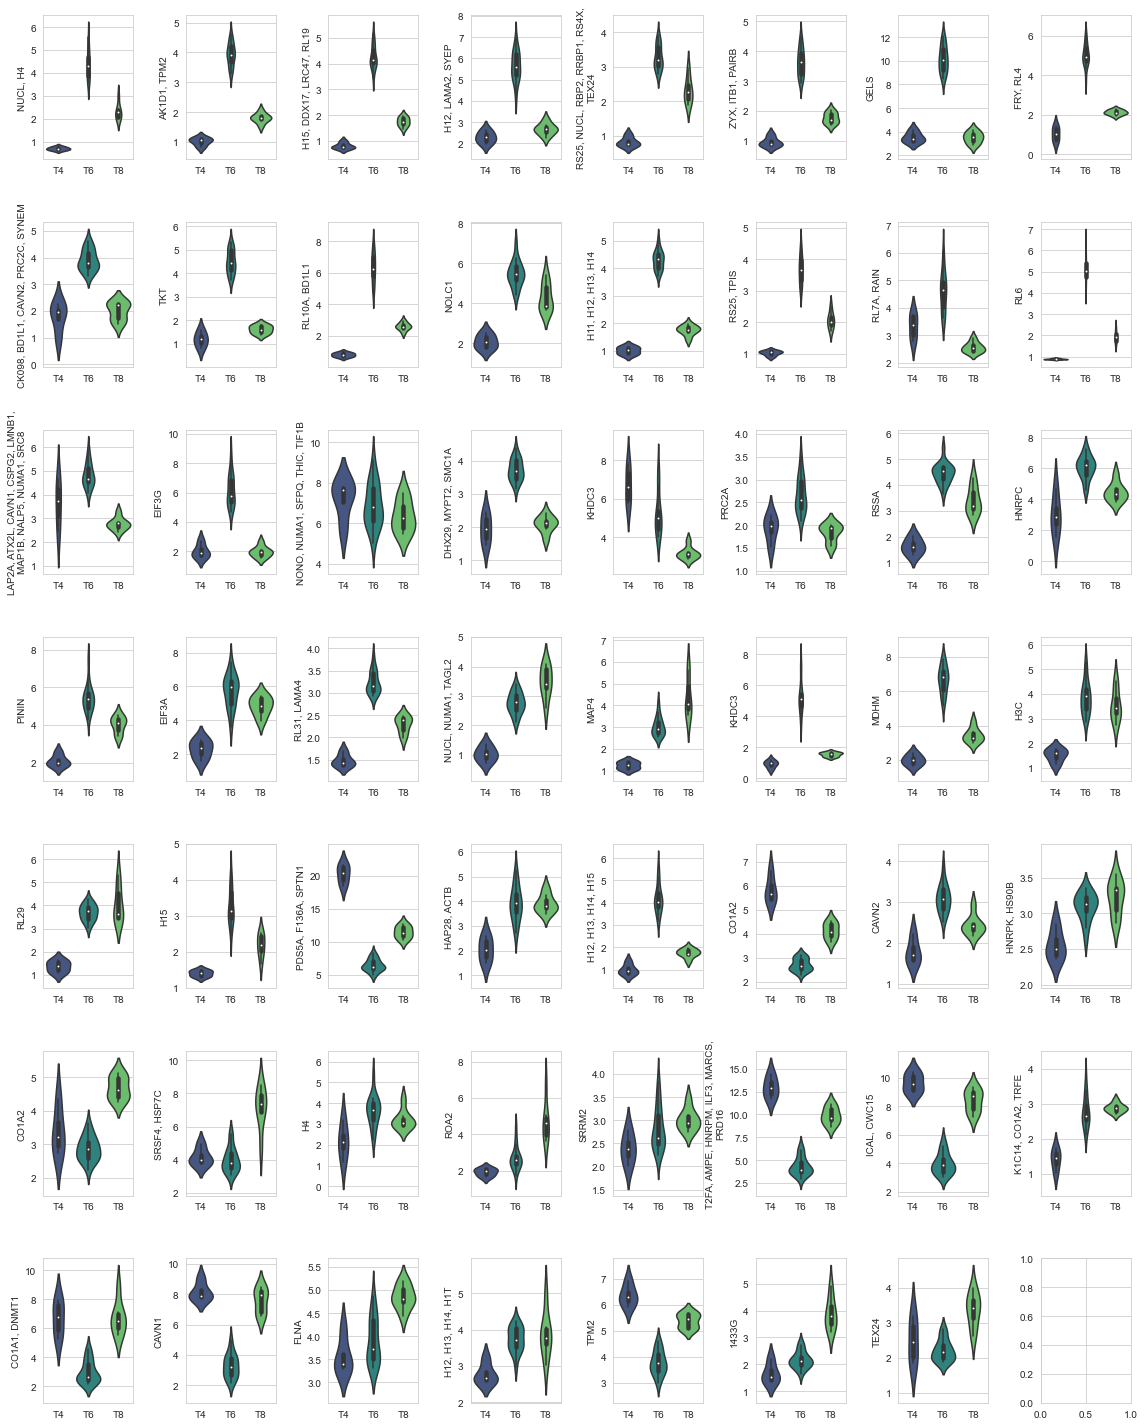

In [169]:
print()
print('                                   Protein distribution across seleceted communities')
n = 8
fig,axes = plt.subplots(7,n)
fig.set_figwidth(16)
fig.set_figheight(20)
i = 0
for k, mz in enumerate(mz_list):
    sns.violinplot(x = 'community', y = mz, data = c_data, ax = axes[i,np.mod(k,n)],palette='viridis')
    axes[i,np.mod(k,n)].set_xlabel('')
    axes[i,np.mod(k,n)].set_xticklabels(communities_types)
    axes[i,np.mod(k,n)].set_ylabel(xticks[k])
    if np.mod(k,n) == n-1:
        i += 1
fig.tight_layout();

Find **Differentially Expressed Proteins (DEPs)** between the communities.

In [174]:
from scipy.stats import mannwhitneyu
DEPs = {}
copy_c_df = c_df.copy()
for c1 in c_df:
    copy_c_df.pop(c1)
    for c2 in copy_c_df:
        DEPs[c1 + '_' + c2] = []
        for mz in mz_list:
            a = c_df[c1][mz]
            b = c_df[c2][mz]
            stat, p = mannwhitneyu(a, b)
            # interpret
            alpha = 0.01
            if p <= alpha:
                DEPs[c1 + '_' + c2].append(mz)

In [182]:
comparison = pd.DataFrame(index = mz_list, columns=diff_prot.keys(),dtype='int')
for c in comparison.columns:
    for mz in mz_list:
        if mz in diff_prot[c]:
            comparison.loc[mz][c] = 1
        else:
            comparison.loc[mz][c] = 0

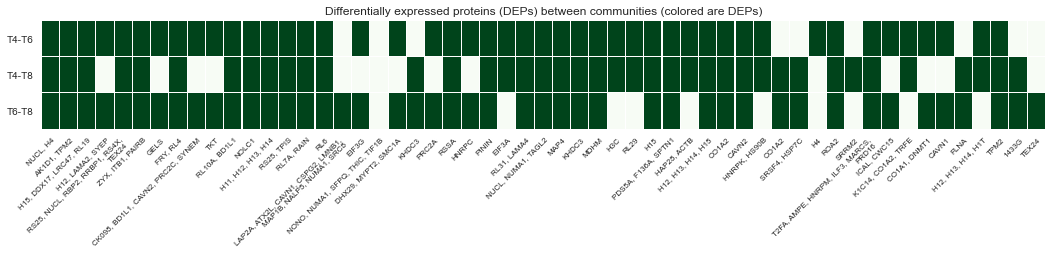

In [231]:
plt.figure(figsize=(18,2))
sns.heatmap(comparison.transpose(),linewidths=0.1, cmap='Greens', cbar=False)
plt.yticks(np.arange(len(comparisons_types))+0.5,comparisons_types, rotation = 0)
plt.xticks(np.arange(len(xticks))+0.8,xticks,rotation=45, fontsize=8, ha='right')
plt.title('Differentially expressed proteins (DEPs) between communities (colored are DEPs)');

## Enrichment analysis

In [285]:
import gseapy as gp
from gseapy.plot import barplot, dotplot
folder = path[:-5] + 'Risultati/EnrichmentResults/CommunityAnalysis/'
DEP_folder = 'DEPs'
Enrichr_folder = 'EnrichrFolder'

In [236]:
DEPlists = [f for f in os.listdir(folder + DEP_folder)]
if '.DS_Store' in DEPlists:
    DEPlists.remove('.DS_Store')

In [246]:
enrichments = {}
save_fig = False
for DEPlist in DEPlists:
    gene_list = pd.read_csv(folder + DEP_folder + '/' + DEPlist, header=None)
    glist = pd.Series(gene_list.squeeze().str.strip()).unique().tolist()
    enr = gp.enrichr(gene_list = glist,
                     gene_sets = ['KEGG_2019_Mouse', 'Mouse_Gene_Atlas', 'WikiPathways_2019_Mouse','Reactome_2016'],
                     description = DEPlist.split('.')[0] + 'comparison',
                     outdir =  Enrichr_folder + '/' + DEPlist.split('.')[0],
                     cutoff=0.5, # adjust p-value cutoff (for plotting)
                     no_plot = False
                    )
    enrichments[DEPlist.split('.')[0]] = enr.results;

2021-01-25 15:39:18,365 Warning: No enrich terms using library Mouse_Gene_Atlas when cutoff = 0.5
2021-01-25 15:39:42,909 Warning: No enrich terms using library Mouse_Gene_Atlas when cutoff = 0.5
2021-01-25 15:40:07,494 Warning: No enrich terms using library Mouse_Gene_Atlas when cutoff = 0.5


> Enrichment results - T4 vs T6

In [284]:
enrichments['T4vsT6'][enrichments['T4vsT6']['Adjusted P-value'] <= 0.05]

,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes,Gene_set
92,Cohesin Loading onto Chromatin Homo sapiens R-...,2/9,0.000531,0.028803,0,0,74.868421,564.557469,PDS5A;SMC1A,Reactome_2016
93,Establishment of Sister Chromatid Cohesion Hom...,2/10,0.000662,0.028803,0,0,65.506579,479.511360,PDS5A;SMC1A,Reactome_2016
94,Mitotic Telophase/Cytokinesis Homo sapiens R-H...,2/13,0.001139,0.033031,0,0,47.633971,322.843534,PDS5A;SMC1A,Reactome_2016


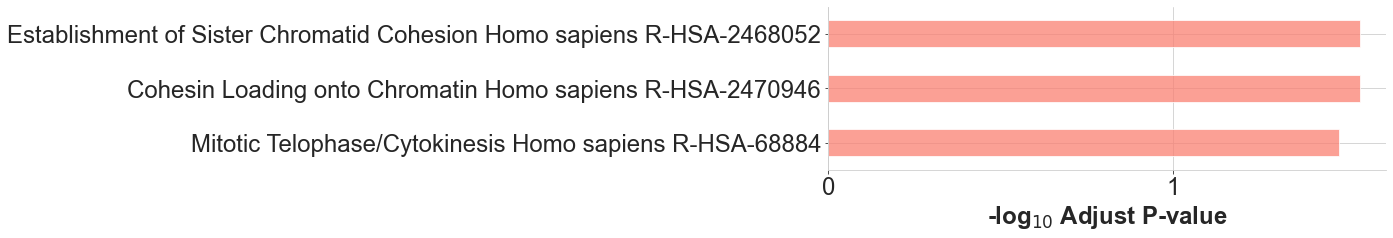

In [288]:
barplot(enrichments['T4vsT6'],figsize=(10,3))

> Enrichment results - T6 vs T8

In [289]:
enrichments['T6vsT8'][enrichments['T6vsT8']['Adjusted P-value'] <= 0.05]

,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes,Gene_set
79,Cohesin Loading onto Chromatin Homo sapiens R-...,2/9,0.000545,0.031241,0,0,73.892393,555.320036,PDS5A;SMC1A,Reactome_2016
80,Establishment of Sister Chromatid Cohesion Hom...,2/10,0.000679,0.031241,0,0,64.652597,471.619562,PDS5A;SMC1A,Reactome_2016
81,Mitotic Telophase/Cytokinesis Homo sapiens R-H...,2/13,0.001168,0.035824,0,0,47.012987,317.446454,PDS5A;SMC1A,Reactome_2016


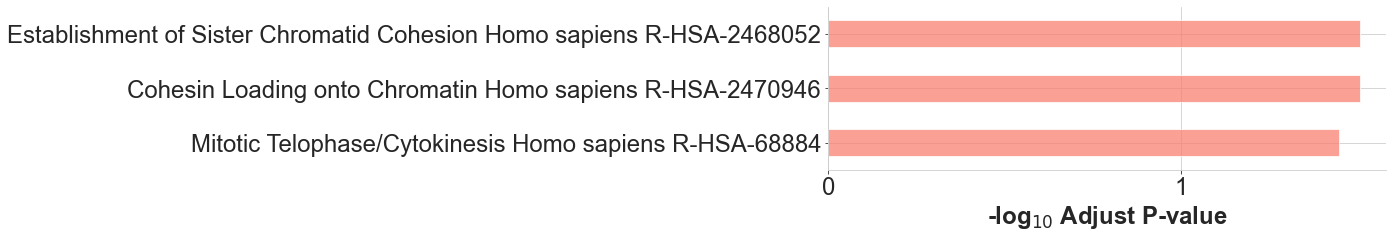

In [290]:
barplot(enrichments['T6vsT8'],figsize=(10,3))

> Enrichment results - T4 vs T8

In [291]:
enrichments['T4vsT8'][enrichments['T4vsT8']['Adjusted P-value'] <= 0.05]

,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes,Gene_set
65,Focal Adhesion WP85,4/185,0.003092,0.037098,0,0,7.156598,41.358621,LAMA4;ZYX;FLNA;ACTB,WikiPathways_2019_Mouse


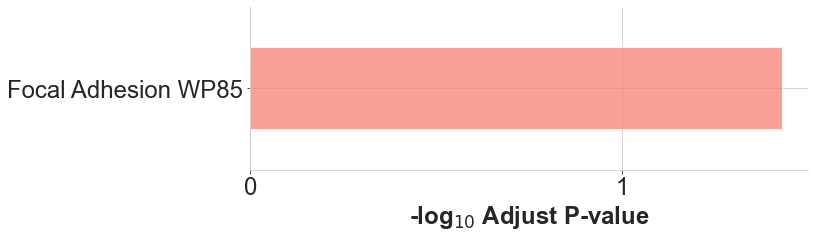

In [298]:
barplot(enrichments['T4vsT8'],figsize=(10,3))